In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
from IPython.display import display # type: ignore
import polars as pl
import matplotlib.pyplot as plt # type: ignore
from raphtory import Graph
from raphtory import algorithms as algo
from typing import List, Tuple
from pathlib import Path
import os
import torch
from torch import Tensor
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import coalesce
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [31]:
#l2g related imports
from l2gv2.patch.clustering import metis_clustering
from l2gv2.graphs import TGraph
from l2gv2.patch.patches import create_patch_data
from l2gv2.datasets import get_dataset

# <font color="grey"> Graph Clustering and Patch Embeddings</font>

###  <a id='chapter1'> <font color="grey">1. The local2global approach </font></a>

The initial step in creating the patch graph consists of clustering the graph. The clusters 

The Cora dataset is a well-known dataset in the field of graph research. This consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [42]:
dataset = get_dataset("Cora")

In [43]:
coral = dataset[0]

In [54]:
coral.num_nodes

2708

In [44]:
# For the time being, use TGraph. Eventually, switch to Raphtory
tgraph = TGraph(coral.edge_index)

In [75]:
num_clusters = 9

In [76]:
cluster_tensor = metis_clustering(tgraph, num_clusters=num_clusters)
cluster_tensor

tensor([7, 0, 5,  ..., 5, 2, 3])

In [77]:
# Visualize
G = to_networkx(coral, to_undirected=True)
node_colors = [cluster_tensor[node].item() for node in G.nodes()]
pos = nx.spring_layout(G, seed=42)

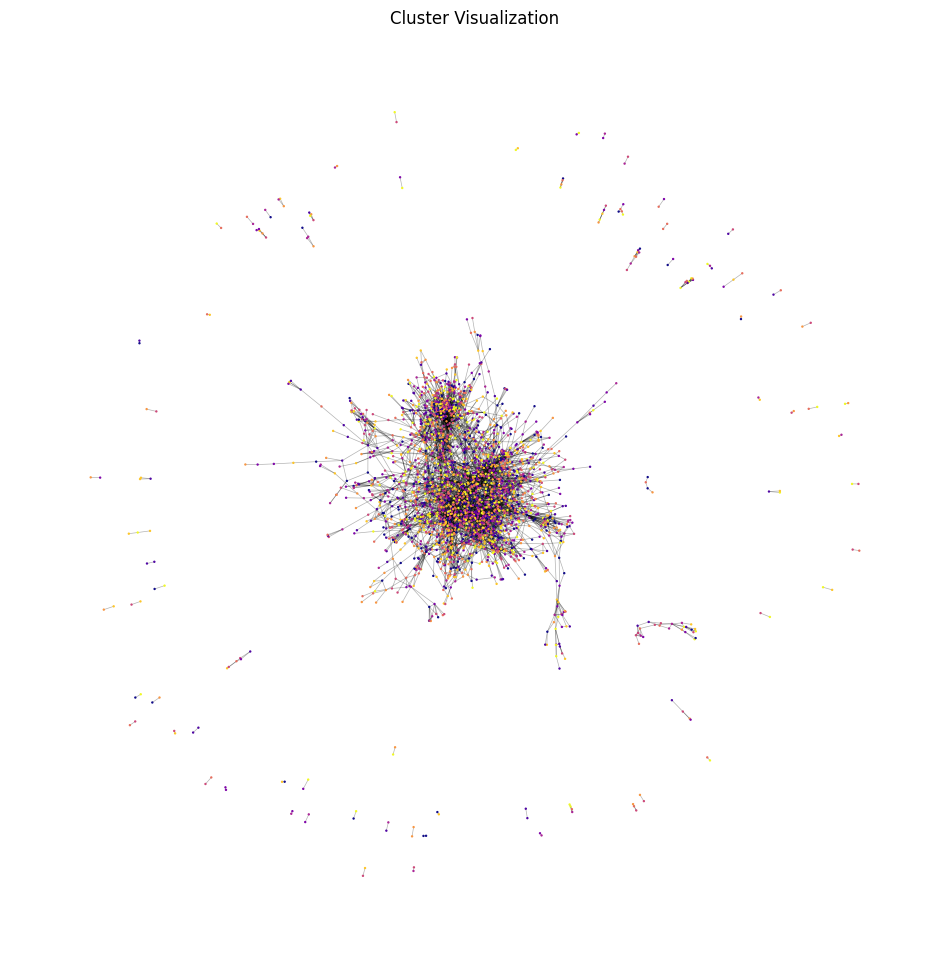

In [78]:
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=0.5, nodelist=list(cent.keys()), cmap=plt.get_cmap('plasma'))
edges = nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.title('Cluster Visualization')
plt.axis('off')
plt.show()

In [79]:
# Compute unique clusters and their counts
unique_clusters, counts = torch.unique(cluster_tensor, return_counts=True)
cluster_counts = dict(zip(unique_clusters.tolist(), counts.tolist()))
print(cluster_counts)

{0: 289, 1: 295, 2: 296, 3: 304, 4: 295, 5: 303, 6: 301, 7: 309, 8: 316}


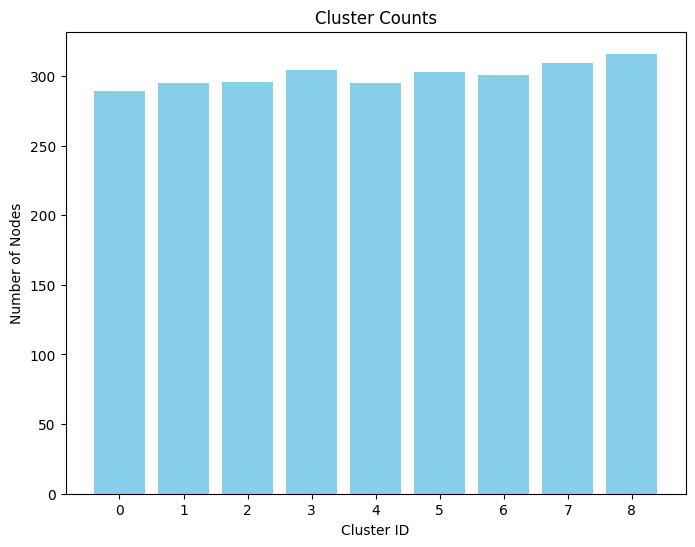

In [80]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(unique_clusters, counts, color='skyblue')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Nodes')
plt.title('Cluster Counts')
plt.xticks(unique_clusters)
plt.show()

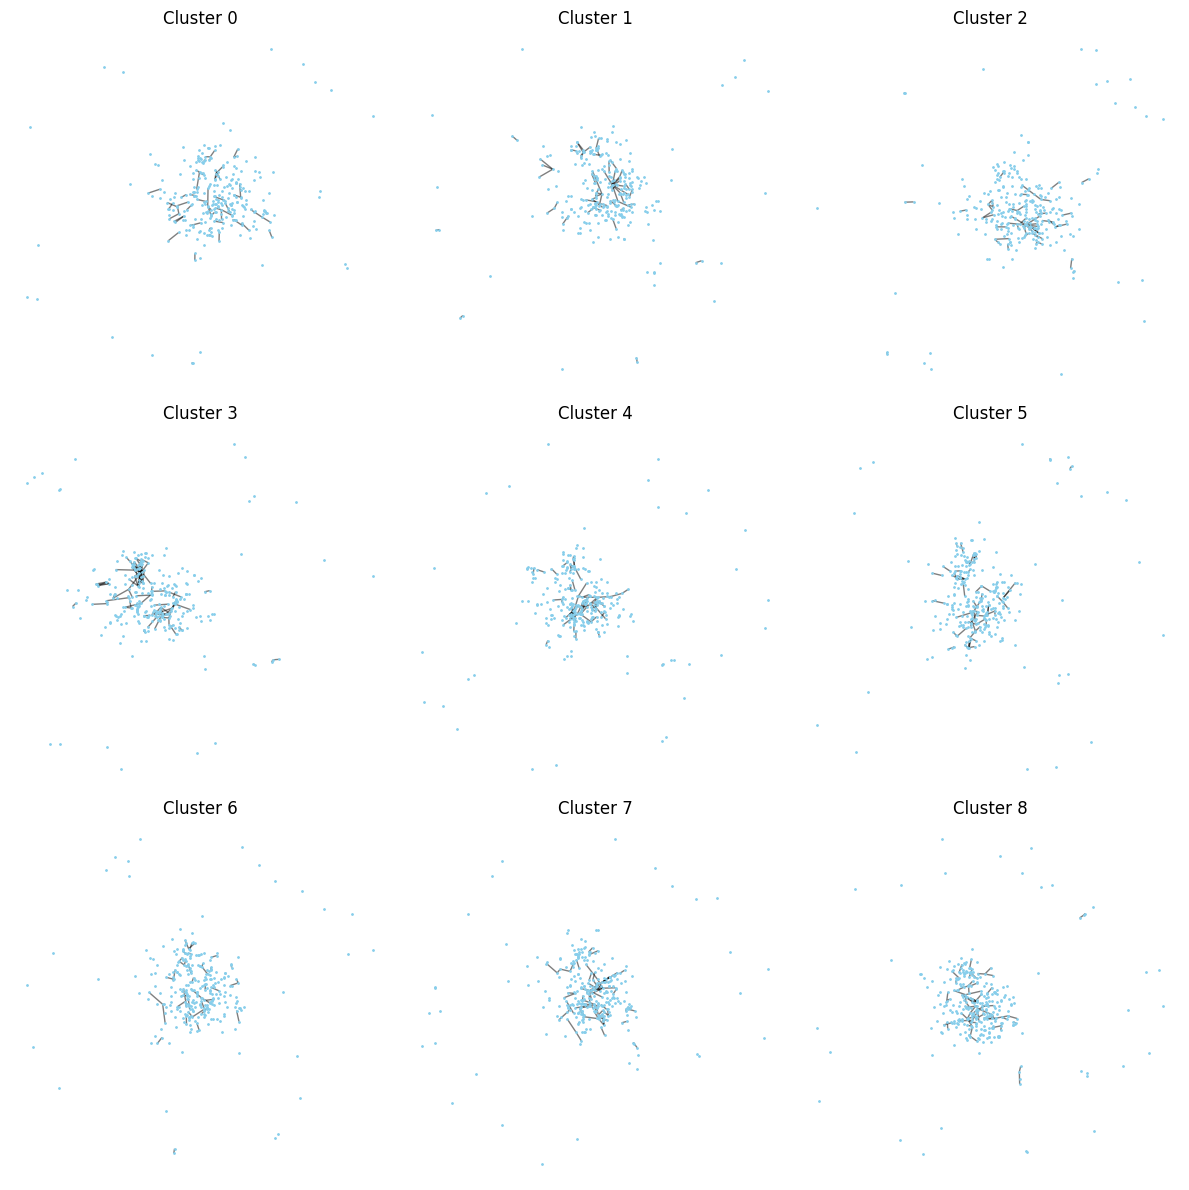

In [86]:
unique_clusters = cluster_tensor.unique().tolist()
n_clusters = len(unique_clusters)
rows = cols = int(np.ceil(np.sqrt(n_clusters)))

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

for i, cluster_id in enumerate(unique_clusters):
    ax = axes[i]
    # Get nodes belonging to the current cluster
    cluster_nodes = [node for node in G.nodes if cluster_tensor[node].item() == cluster_id]
    subgraph = G.subgraph(cluster_nodes)
    
    # Plot the subgraph
    nx.draw_networkx_nodes(subgraph, pos, ax=ax, node_size=1, node_color='skyblue')
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.5, width=1)
    
    ax.set_title(f"Cluster {cluster_id}")
    ax.axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def hierarchical_cluster_and_embed(graph: TGraph, m: int, k: int) -> List[Tuple[nx.Graph, List[float]]]:
    if graph.number_of_nodes() <= m:
        return [(graph, embed(graph))]
    
    clusters = cluster(graph, k)
    results = []
    
    for subgraph in clusters:
        results.extend(hierarchical_cluster_and_embed(subgraph, m, k))
    
    return results